# HW3 Image Classification
## We strongly recommend that you run with Kaggle for this homework


# Get Data
Notes: if the links are dead, you can download the data directly from Kaggle and upload it to the workspace, or you can use the Kaggle API to directly download the data into colab.


In [1]:
#! wget https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip

--2022-03-03 16:00:33--  https://www.dropbox.com/s/6l2vcvxl54b0b6w/food11.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/6l2vcvxl54b0b6w/food11.zip [following]
--2022-03-03 16:00:33--  https://www.dropbox.com/s/raw/6l2vcvxl54b0b6w/food11.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc89a27633917a4649a0be64a578.dl.dropboxusercontent.com/cd/0/inline/BgyJHeT6ktWDUrjn1ICVCKVKisZAPQ-U6XE5iG-7Ye0cfXKUIcIaGKMUheJbLTVEZwHHa0ItvsK_PHCGSIF0btVayn5I-HuYxHaCYSFPR0xnoCjldEK9c2FMxJDdJBOjtN7PpWcGTf0RhCES_KSSPzU0/file# [following]
--2022-03-03 16:00:33--  https://uc89a27633917a4649a0be64a578.dl.dropboxusercontent.com/cd/0/inline/BgyJHeT6ktWDUrjn1ICVCKVKisZAPQ-U6XE5iG-7Ye0cfXKUIcIaGKMUheJbLTVEZwHHa0ItvsK_PHCGSIF0btVayn5I-HuY

In [9]:
#! unzip food11.zip

Streaming output truncated to the last 5000 lines.
  inflating: food11/training/8_806.jpg  
  inflating: food11/training/8_807.jpg  
  inflating: food11/training/8_808.jpg  
  inflating: food11/training/8_809.jpg  
  inflating: food11/training/8_81.jpg  
  inflating: food11/training/8_810.jpg  
  inflating: food11/training/8_811.jpg  
  inflating: food11/training/8_812.jpg  
  inflating: food11/training/8_813.jpg  
  inflating: food11/training/8_814.jpg  
  inflating: food11/training/8_815.jpg  
  inflating: food11/training/8_816.jpg  
  inflating: food11/training/8_817.jpg  
  inflating: food11/training/8_818.jpg  
  inflating: food11/training/8_819.jpg  
  inflating: food11/training/8_82.jpg  
  inflating: food11/training/8_820.jpg  
  inflating: food11/training/8_821.jpg  
  inflating: food11/training/8_822.jpg  
  inflating: food11/training/8_823.jpg  
  inflating: food11/training/8_824.jpg  
  inflating: food11/training/8_825.jpg  
  inflating: food11/training/8_826.jpg  
  inflat

# Training

In [11]:
_exp_name = "sample"

In [2]:
# Import necessary packages.
import numpy as np
import pandas as pd
import torch
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

C:\Users\ycho\anaconda3\envs\common\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import numpy as np

#fix seed
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  
    np.random.seed(seed)  
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
seed = 0
same_seeds(seed)

In [4]:
# myseed = 0  # set a random seed for reproducibility
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
# np.random.seed(myseed)
# torch.manual_seed(myseed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [5]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [6]:
class FoodDataset(Dataset):

    def __init__(self,path,tfm=test_tfm,files = None):
        super(FoodDataset).__init__()
        self.path = path
        self.files = sorted([os.path.join(path,x) for x in os.listdir(path) if x.endswith(".jpg")])
        if files != None:
            self.files = files
        print(f"One {path} sample",self.files[0])
        self.transform = tfm
  
    def __len__(self):
        return len(self.files)
  
    def __getitem__(self,idx):
        fname = self.files[idx]
        im = Image.open(fname)
        im = self.transform(im)
        #im = self.data[idx]
        try:
            label = int(os.path.basename(fname).split("_")[0])
        except:
            label = -1 # test has no label
        return im,label



In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)
    
    
from torch import nn
class Residual_Network(nn.Module):
    def __init__(self):
        super(Residual_Network, self).__init__()
        
        self.cnn_layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
        )

        self.cnn_layer3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128),
        )

        self.cnn_layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
        )
        self.cnn_layer5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256),
        )
        self.cnn_layer6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(256* 32* 32, 256),
            nn.ReLU(),
            nn.Linear(256, 11)
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        # input (x): [batch_size, 3, 128, 128]
        # output: [batch_size, 11]

        # Extract features by convolutional layers.
        x1 = self.cnn_layer1(x)
        
        x1 = self.relu(x1)
        
        x2 = self.cnn_layer2(x1)
        
        x2 = self.relu(x2)
        
        x3 = self.cnn_layer3(x2)
        
        x3 = self.relu(x3)
        
        x4 = self.cnn_layer4(x3)
        
        x4 = self.relu(x4)
        
        x5 = self.cnn_layer5(x4)
        
        x5 = self.relu(x5)
        
        x6 = self.cnn_layer6(x5)
        
        x6 = self.relu(x6)
        
        # The extracted feature map must be flatten before going to fully-connected layers.
        xout = x6.flatten(1)

        # The features are transformed by fully-connected layers to obtain the final logits.
        xout = self.fc_layer(xout)
        return xout

In [8]:
batch_size = 64
_dataset_dir = "./food11"
# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = FoodDataset(os.path.join(_dataset_dir,"training"), tfm=train_tfm)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_set = FoodDataset(os.path.join(_dataset_dir,"validation"), tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

One ./food11\training sample ./food11\training\0_0.jpg
One ./food11\validation sample ./food11\validation\0_0.jpg


In [9]:
# "cuda" only when GPUs are available.
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE: {device}')

# The number of training epochs and patience.
n_epochs = 3
patience = 300 # If no improvement in 'patience' epochs, early stop

# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
#model = Residual_Network().to(device)

# For the classification task, we use cross-entropy as the measurement of performance.
criterion = nn.CrossEntropyLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5) 

DEVICE: cuda:0


In [12]:

# Initialize trackers, these are not parameters and should not be changed
stale = 0
best_acc = 0

for epoch in range(n_epochs):

    # ---------- Training ----------
    # Make sure the model is in train mode before training.
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []

    for batch in tqdm(train_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()
        #print(imgs.shape,labels.shape)

        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))

        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        loss = criterion(logits, labels.to(device))

        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        train_loss.append(loss.item())
        train_accs.append(acc)
        
    train_loss = sum(train_loss) / len(train_loss)
    train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")

    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #imgs = imgs.half()

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        loss = criterion(logits, labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)
        #break

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)

    # Print the information.
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # update logs
    if valid_acc > best_acc:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f} -> best")
    else:
        with open(f"./{_exp_name}_log.txt","a"):
            print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")


    # save models
    if valid_acc > best_acc:
        print(f"Best model found at epoch {epoch}, saving model")
        torch.save(model.state_dict(), f"{_exp_name}_best.ckpt") # only save best to prevent output memory exceed error
        best_acc = valid_acc
        stale = 0
    else:
        stale += 1
        if stale > patience:
            print(f"No improvment {patience} consecutive epochs, early stopping")
            break

100%|██████████| 157/157 [01:48<00:00,  1.44it/s]


[ Train | 001/003 ] loss = 1.55549, acc = 0.45959


100%|██████████| 57/57 [00:29<00:00,  1.93it/s]


[ Valid | 001/003 ] loss = 1.57899, acc = 0.47043
[ Valid | 001/003 ] loss = 1.57899, acc = 0.47043 -> best
Best model found at epoch 0, saving model


100%|██████████| 157/157 [01:44<00:00,  1.51it/s]


[ Train | 002/003 ] loss = 1.36933, acc = 0.52926


100%|██████████| 57/57 [00:29<00:00,  1.91it/s]


[ Valid | 002/003 ] loss = 1.44116, acc = 0.50364
[ Valid | 002/003 ] loss = 1.44116, acc = 0.50364 -> best
Best model found at epoch 1, saving model


100%|██████████| 157/157 [01:47<00:00,  1.46it/s]


[ Train | 003/003 ] loss = 1.21148, acc = 0.57972


100%|██████████| 57/57 [00:30<00:00,  1.88it/s]

[ Valid | 003/003 ] loss = 1.54765, acc = 0.47084
[ Valid | 003/003 ] loss = 1.54765, acc = 0.47084


In [13]:
test_set = FoodDataset(os.path.join(_dataset_dir,"test"), tfm=test_tfm)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

One ./food11\test sample ./food11\test\0000.jpg


# Testing and generate prediction CSV

In [14]:
#model_best = Residual_Network().to(device) #
model_best = Classifier().to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt"))
model_best.eval()
prediction = []
with torch.no_grad():
    for data,_ in test_loader:
        test_pred = model_best(data.to(device))
        test_label = np.argmax(test_pred.cpu().data.numpy(), axis=1)
        prediction += test_label.squeeze().tolist()

C:\Users\ycho\AppData\Local\Temp\ipykernel_29272\3698650339.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_best.load_state_dict(torch.load(f"{_exp_name}_best.ckpt

In [15]:
#create test csv
def pad4(i):
    return "0"*(4-len(str(i)))+str(i)
df = pd.DataFrame()
df["Id"] = [pad4(i) for i in range(1,len(test_set)+1)]
df["Category"] = prediction
df.to_csv("submission.csv",index = False)

# Q1. Augmentation Implementation
## Implement augmentation by finishing train_tfm in the code with image size of your choice. 
## Directly copy the following block and paste it on GradeScope after you finish the code
### Your train_tfm must be capable of producing 5+ different results when given an identical image multiple times.
### Your  train_tfm in the report can be different from train_tfm in your training code.


In [ ]:
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((128, 128)),
    # You need to add some transforms here.
    transforms.ToTensor(),
])

# Q2. Visual Representations Implementation
## Visualize the learned visual representations of the CNN model on the validation set by implementing t-SNE (t-distributed Stochastic Neighbor Embedding) on the output of both top & mid layers (You need to submit 2 images).

Code Source: https://colab.research.google.com/drive/15A_8ilH-6-T3HOmSFrKbjDinBJl-s-16#scrollTo=QcBKUNfc3BeL  


In [18]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the trained model
model = Classifier().to(device)
state_dict = torch.load(f"{_exp_name}_best.ckpt")
model.load_state_dict(state_dict)
model.eval()

print(model)

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


C:\Users\ycho\AppData\Local\Temp\ipykernel_29272\1370318947.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f"{_exp_name}_best.ckpt")


One ./food11/test_plot sample ./food11/test_plot\0_86.jpg


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


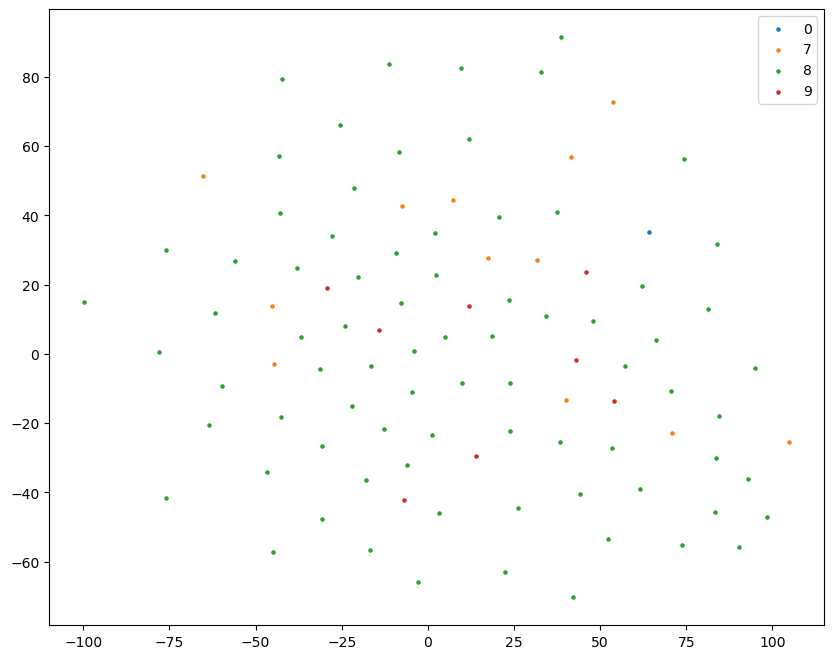

In [42]:
# Unit test - just pick 155 pictures
valid_set = FoodDataset("./food11/test_plot", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 11 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()


In [32]:
len(model.cnn)
model.cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool2d(kernel_size=2, s

One ./food11/test_plot sample ./food11/test_plot\0_86.jpg


100%|██████████| 2/2 [00:02<00:00,  1.41s/it]


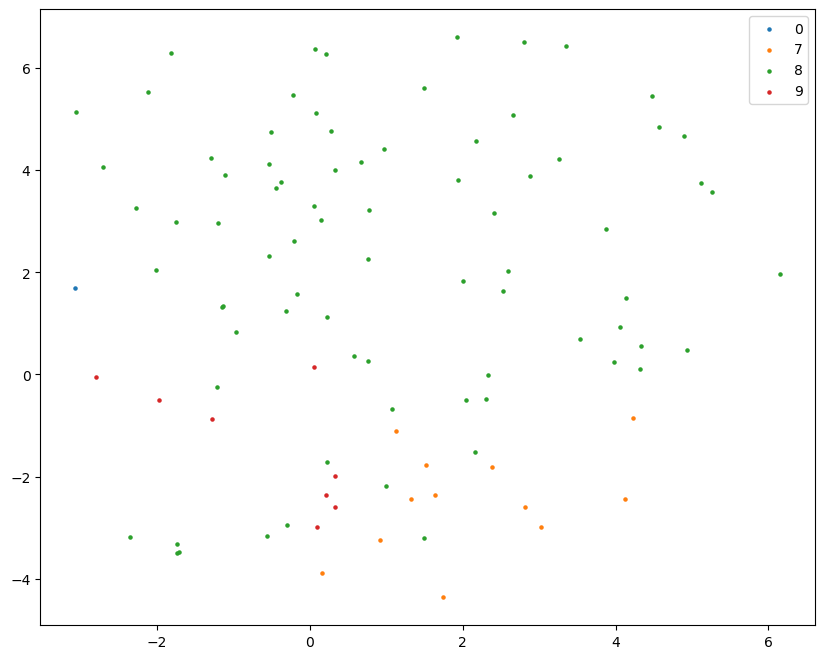

In [43]:
# Unit test - just pick 155 pictures
valid_set = FoodDataset("./food11/test_plot", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 19 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

One ./food11/validation sample ./food11/validation\0_0.jpg


100%|██████████| 57/57 [00:37<00:00,  1.52it/s]


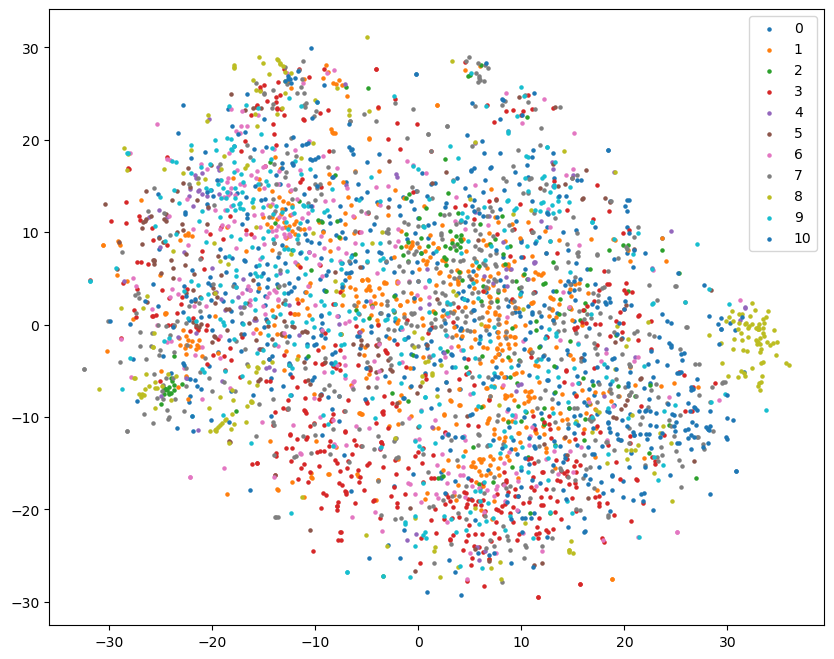

In [38]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./food11/validation", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 12 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()

One ./food11/validation sample ./food11/validation\0_0.jpg


100%|██████████| 57/57 [00:34<00:00,  1.64it/s]


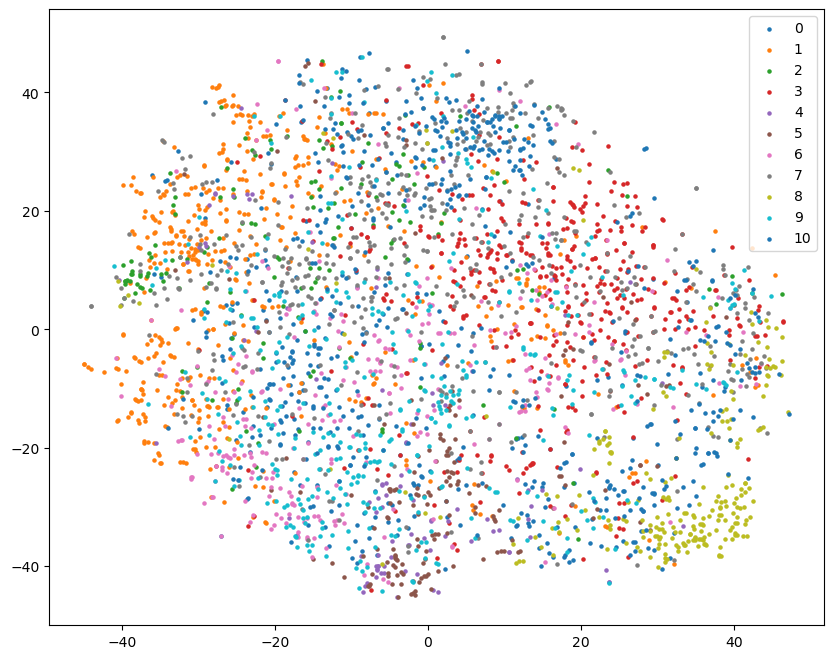

In [41]:
# Load the vaildation set defined by TA
valid_set = FoodDataset("./food11/validation", tfm=test_tfm)
valid_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=0, pin_memory=True)

# Extract the representations for the specific layer of model
index = 19 # You should find out the index of layer which is defined as "top" or 'mid' layer of your model.
features = []
labels = []
for batch in tqdm(valid_loader):
    imgs, lbls = batch
    with torch.no_grad():
        logits = model.cnn[:index](imgs.to(device))
        logits = logits.view(logits.size()[0], -1)
    labels.extend(lbls.cpu().numpy())
    logits = np.squeeze(logits.cpu().numpy())
    features.extend(logits)

features = np.array(features)
colors_per_class = cm.rainbow(np.linspace(0, 1, 11))

# Apply t-SNE to the features
features_tsne = TSNE(n_components=2, init='pca', random_state=42).fit_transform(features)

# Plot the t-SNE visualization
plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    plt.scatter(features_tsne[labels == label, 0], features_tsne[labels == label, 1], label=label, s=5)
plt.legend()
plt.show()